## Transform Data

In [ ]:
# Transformers

numerical_transformer = Pipeline(
                            steps = [("imputer", SimpleImputer()),
                                     ("scaler", StandardScaler())]
                                )

nominal_transformer = Pipeline(
                        steps = [("imputer", SimpleImputer(strategy = nominal_imputer_strategy)),
                                 ("te", TargetEncoder(target_type = "multiclass"))]
                              )

preprocessor = ColumnTransformer(
                        transformers = [("nominal", nominal_transformer, nominal_attr),
                                        ("numerical", numerical_transformer, numerical_attr)
                                ]
                        )

In [ ]:
transformed_data = preprocessor.fit_transform(train_df, train_df[target])
cols = preprocessor.get_feature_names_out().tolist()

transformed_df = pd.DataFrame(data = transformed_data, columns=cols)
transformed_df

In [ ]:
print(f'Number of attrinutes after TargetEncoding: {transformed_df.shape[1]}')
print()
print("Column Names:")
for num, col in enumerate(cols):
    print(f"{num+1}: {col}")

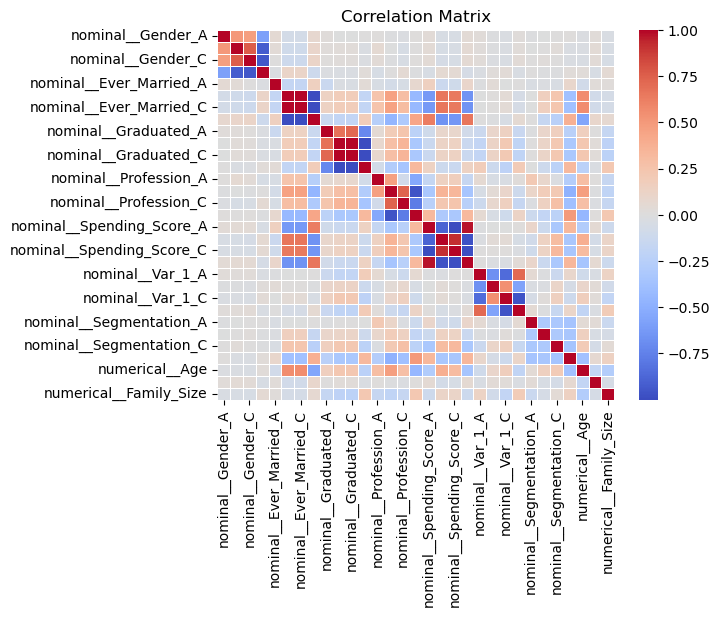

In [ ]:
# Correlation
def plot_correlation_matrix(df, annot=True):
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=annot, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

plot_correlation_matrix(transformed_df, annot=False)

In [ ]:
# # get normalized class summaries
# trans_feature_and_target = pd.concat([transformed_df, train_df[target]], axis=1)

# norm_class_summary_df = trans_feature_and_target.groupby(target).mean()

# print("Normalized Class Summaries (Z-Score Normalization):")
# norm_class_summary_df

In [ ]:
# # Plot heatmap of normalized class summaries
# plt.figure(figsize=(10, 6))
# sns.heatmap(norm_class_summary_df, annot=False, cmap='coolwarm', linewidths=0.5)
# plt.title('Heatmap of Normalized Class Summaries')
# plt.xlabel('Features')
# plt.xticks(rotation=45, ha='right')
# plt.ylabel('Class')
# plt.show()

In [ ]:
# Target class EDA

# # drop NaNs
# cleaned_df = train_df[ml_attr_dict['ML_attr']].dropna()
# feature_df = cleaned_df.iloc[:, :-1].copy()
# target_df = cleaned_df[target].copy()

# # Dummy encoding
# enc_featre_df = pd.get_dummies(feature_df, dtype=int)
# encoded_df = pd.concat([enc_featre_df, target_df], axis=1)
# encoded_df

In [ ]:
# from sklearn.preprocessing import StandardScaler

# # Initialize  StandardScaler
# scaler = StandardScaler()

# # Normalize the class summaries
# norm_enc_feature_df = pd.DataFrame(scaler.fit_transform(enc_featre_df), 
#                                     columns=enc_featre_df.columns, 
#                                     index=enc_featre_df.index)
# norm_enc_df = pd.concat([norm_enc_feature_df, target_df], axis=1)
# norm_enc_df

In [ ]:
# # Correlation
# def plot_correlation_matrix(df, annot):
#     corr_matrix = df.corr()
#     sns.heatmap(corr_matrix, annot=annot, cmap='coolwarm', linewidths=0.5)
#     plt.title('Correlation Matrix')
#     plt.show()

# plot_correlation_matrix(norm_enc_df.iloc[:, :-1], annot=False)

In [ ]:
from sklearn.neighbors import KDTree


def get_NN(cap_x):
    '''
    Description: Returns nearest neighbors distances list.

    Parameters:
            cap_x (np.ndarray): design matrix
    Returns:
            nn_dist_list (list): list of nearest neighbors
            
    Documentation:
        https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html

    '''
        
    # build the kdtree
    kdt = KDTree(cap_x)

    nn_dist_list = []
    for i in range(cap_x.shape[0]):
        dist, indices = kdt.query(cap_x[i, :].reshape(1, -1), 2)
        nn_dist_list.append(dist[0, -1])

    return nn_dist_list

def get_hopkins(cap_x):
    '''
    Description: Calculates hopkin's statistic for embedding.

        cap_h = sum(cap_x_nn_dist_list) / (sum(randomly_nn_dist_list) + sum(cap_x_nn_dist_list))

    Parameters:
            cap_x (np.ndarray): design matrix
    Returns:
            cap_h (float): hopkin's statistic value
    '''

    # seed random
    np.random.seed(18)

    # get uniformly randomley distributed data
    data_max = cap_x.max(axis=0)
    data_min = cap_x.min(axis=0)
    random_dist_data = np.random.uniform(low=data_min, high=data_max, size=cap_x.shape)

    ## null hypothesis: get nearest neighbor distance (random data)

    # get list of nearest neighbors for random data
    randomly_nn_dist_list = get_NN(random_dist_data)

    # get nearest neighbor distance from embedding
    cap_x_nn_dist_list = get_NN(cap_x)

    # calculate hopkins
    cap_h = sum(cap_x_nn_dist_list) / (sum(randomly_nn_dist_list) + sum(cap_x_nn_dist_list))

    return cap_h



In [ ]:
import warnings
import umap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
warnings.filterwarnings("ignore", message="n_jobs value")



for k in range(2, target_df.nunique() + 1):
    for n in range(2, 8):

        print(f"\n***** k = {k} and n_components = {n} *****")

        clustering_df = norm_enc_df.copy()

        # Create a UMAP reducer
        umap_reducer = umap.UMAP(n_neighbors=15, n_components=n, random_state=random_state)

        # Fit and transform the data
        X_umap = umap_reducer.fit_transform(norm_enc_feature_df.to_numpy())

        # Reduce to k for simple classification
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        clustering_df[target] = kmeans.fit_predict(X_umap)
        
        # Get Hopkins
        hopkins = get_hopkins(X_umap)
        print(f"Hopkin's Statistic for k={k}: {hopkins:.2f}")

        # Silhoutte score
        sil_score = silhouette_score(clustering_df.loc[:, :target], clustering_df[target])
        print(f'Silhouette Score for k={k}: {sil_score:.2f}')

        # PCA for plotting
        pca = PCA(n_components=2, random_state=random_state)
        X_pca = pca.fit_transform(clustering_df.iloc[:, :-1])
        

        # Plot the clustered targets
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clustering_df[target], cmap='viridis', s=100)
        plt.title(f'Kmeans Clustering of Target Classes Based on Feature Matrix with k={k}')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.colorbar(label='Clustered Target')
        plt.show()

        tsne = TSNE(n_components=2, random_state=random_state)
        X_tsne = tsne.fit_transform(clustering_df.iloc[:, :-1])

        # Step 5: Visualize the clustered data using t-SNE
        plt.figure(figsize=(8, 6))
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clustering_df[target], cmap='viridis', s=50)
        plt.colorbar(label='Cluster Label')
        plt.title("t-SNE Visualization of Clusters", fontsize=14)
        plt.xlabel("t-SNE Feature 1")
        plt.ylabel("t-SNE Feature 2")
        plt.show()

        del clustering_df



In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

for k in range(2, target_df.nunique() + 1):

    print(f"\n***** k = {k} *****")

    clustering_df = norm_enc_df.copy()

    # Reduce to k for simple classification
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    class_labels = kmeans.fit_predict(norm_class_summary_df)

    # Create mapping
    target_cluster_map = {old_class: cluster_label for old_class, cluster_label in zip(norm_class_summary_df.index, class_labels)}
    print("\nTarget to Cluster Map:", target_cluster_map)

    # Reassign target labels
    clustering_df[target] = clustering_df[target].map(target_cluster_map)

    # Get Hopkins
    hopkins = get_hopkins(norm_enc_feature_df.to_numpy())
    print(f"Hopkin's Statistic for k={k}: {hopkins:.2f}")

    # Silhoutte score
    sil_score = silhouette_score(clustering_df.loc[:, :target], clustering_df[target])
    print(f'Silhouette Score for k={k}: {sil_score:.2f}')

    # PCA for plotting
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(clustering_df.iloc[:, :-1])

    # Plot the clustered targets
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clustering_df[target], cmap='viridis', s=100)
    plt.title(f'Kmeans Clustering of Target Classes Based on Feature Summaries with k={k}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Clustered Target')
    plt.show()


    # del clustering_df